In [976]:
import geopandas as gpd
import numpy as np
from typing import *
import json
import requests
from io import BytesIO
import zipfile
import time
from scipy.interpolate import RegularGridInterpolator, NearestNDInterpolator


def get_file_name(latitude: float, longitude: float) -> str:
    '''
    from SRTM.py. find srtm file name with lat lon.

    parameters
    ----------
    latitude (float) : point latitude (epsg 4326)
    longitude (float) : point longitude (epsg 4326)

    returns
    ----------
    filename ex: N45W074.hgt
    '''

    if latitude >= 0:
        north_south = 'N'
    else:
        north_south = 'S'

    if longitude >= 0:
        east_west = 'E'
    else:
        east_west = 'W'

    file_name = '%s%s%s%s.hgt' % (north_south, str(int(abs(np.floor(latitude)))).zfill(2),
                                  east_west, str(int(abs(np.floor(longitude)))).zfill(3))
    return file_name



def fetch_data(url: str) -> None:
    '''
    fetch SRTM zip file and extract it as tmp/<fileName>.hgt

    parameters
    ----------
    url (str) : URL of the .zip file to fetch

    returns
    ----------
    Nothing. save file in tmp/ folder
    '''
     
    try:
        response = requests.get(url)
        buffer = BytesIO(response.content)
        with zipfile.ZipFile(buffer, "r") as zip_ref:
            zip_ref.extractall('tmp')
            print('file save tmp/')
    except:
        time.sleep(2)
        response = requests.get(url)
        buffer = BytesIO(response.content)
        with zipfile.ZipFile(buffer, "r") as zip_ref:
            zip_ref.extractall('tmp')
            print('file save to tmp/')
    



def read_hgt_file(hgt_file: str, arc: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]: 
    '''
    read hgt file, extract the matrix data and the lat lon values

    parameters
    ----------
    hgt_file (str) : path of the .hgt file
    arc (int) : resolution on the hgt file. srtm1 : 1, srtm3: 3, etc

    returns
    ----------
    elevation (np.array) : matrix (N X N) elevation[lon, lat]
    lat (np.array) : vector  (N x 1)
    lon (np.array) : vector (N X 1)
    '''

    SAMPLES = int(3600/arc +1)

    filename = hgt_file.split('/')[-1]

    if filename.split('S')[0] != filename: lat0 = -int(filename.split('S')[-1][0:2])
    if filename.split('N')[0] != filename: lat0 =  int(filename.split('N')[-1][0:2])
    if filename.split('W')[0] != filename: lon0 = -int(filename.split('W')[-1][0:3])
    if filename.split('E')[0] != filename: lon0 =  int(filename.split('E')[-1][0:3])

    lat = np.linspace(lat0, lat0 + 1, SAMPLES)
    lon = np.linspace(lon0, lon0 + 1, SAMPLES)

    with open(hgt_file, 'rb') as hgt_data:
        # Each data is 16bit signed integer(i2) - big endian(>)
        elevation = np.fromfile(hgt_data, np.dtype('>i2'), SAMPLES*SAMPLES)\
                                .reshape((SAMPLES, SAMPLES))
        return np.flip(elevation, axis=0).T, lat, lon
    
def fill_missing_elevation(alt: np.ndarray) -> np.ndarray:
    '''
    NaN value are equal to -32768. Interpolated those value with kneighbor

    parameters
    ----------
    alt: np.ndarray = Matrix of elevation (from read_hgt_file())

    returns
    ----------
    alt: np.ndarray = Matrix of elevation with missing value interpolated from kneighbor
    '''
    mask = np.where(alt != -32768)
    interp = NearestNDInterpolator(np.transpose(mask), alt[mask])
    interp_alt = interp(*np.indices(alt.shape))
    return interp_alt
    
def interpolate_elevation(lon_list: List[float], lat_list: List[float], alt: np.ndarray, lon: np.ndarray, lat:np.ndarray) -> List[int]:
    '''
    find elevation value at any point with 2d interpolation of SRTM matrix

    parameters
    ----------
    lon_list: List[float] = list (or np.ndaray) of longitude to interpolate
    lat_list: List[float] = list (or np.ndaray) of latitude to interpolate
    alt: np.ndarray = Matrix of elevation (from read_hgt_file())
    lon: np.ndarray = vector of longidude for the matrix (from read_hgt_file())
    lat: np.ndarray = vector of latitude for the matrix (from read_hgt_file())

    returns
    ----------
    List[int] elevation (meters) at each point values are rounded to int.
    '''


    interp = RegularGridInterpolator((lon, lat), alt, bounds_error=False, fill_value=None)

    return [ int(interp(tup)) for tup in zip(lon_list, lat_list)]

In [977]:
df = gpd.read_file('test/nodes_ny.geojson')
df = df.set_index('index')

In [978]:
def get_elevation_from_srtm(tdf:gpd.GeoDataFrame) -> Dict[Any,int]:
    '''
    find elevation value for every points in a GeoDataFrame

    parameters
    ----------
    tdf: gpd.GeoDataFrame = gpd to of points in EPSG:4326

    returns
    ----------
    {index: elevation} : Dict[Any,int] = elevataion for each index in the GeoDataFrame
    '''
    
    df = tdf.copy()
    srtm = 'srtm3' # srtm1 is not working in montreal. only available in the US but the file exist in montreal...
    arc_dict= {'srtm1':1,'srtm3':3}


    # lon is est west
    # lat is north south
    #get lon lat from geometry
    lonlat_list = [ list((geom.xy[0][0], geom.xy[1][0])) for geom in df['geometry'].values ]
    df[['lon','lat']] = lonlat_list

    # get eachPoint file to fetch
    df['file_name'] = df.apply(lambda x: get_file_name(x['lat'],x['lon']),axis=1)

    # read dict [fileName : url] from srtm.py python librairy
    with open('url_list.json') as file:
        data = json.load(file)

    el_dict = {}
    for file in list(df['file_name'].unique()):

        temp_df = df[df['file_name']==file].copy()

        url = data[srtm][file]

        fetch_data(url)

        alt, lat, lon = read_hgt_file('tmp/{f}'.format(f=file),arc_dict[srtm])
        
        alt = fill_missing_elevation(alt)
        
        temp_df['elevation'] = interpolate_elevation(temp_df['lon'].values,temp_df['lat'].values, alt, lon, lat)

        el_dict.update(temp_df['elevation'].to_dict())

    #df['elevation'] = df.index.map(el_dict.get)
    return el_dict


In [979]:
df['elevation'] = df.index.map(el_dict.get)

In [980]:

srtm = 'srtm3' # srtm1 is not working in montreal. only available in the US but the file exist in montreal...
arc_dict= {'srtm1':1,'srtm3':3}


# lon is est west
# lat is north south
#get lon lat from geometry
lonlat_list = [ list((geom.xy[0][0], geom.xy[1][0])) for geom in df['geometry'].values ]
df[['lon','lat']] = lonlat_list

# get eachPoint file to fetch
df['file_name'] = df.apply(lambda x: get_file_name(x['lat'],x['lon']),axis=1)

# read dict [fileName : url] from srtm.py python librairy
with open('url_list.json') as file:
    data = json.load(file)

el_dict = {}
for file in list(df['file_name'].unique()):

    temp_df = df[df['file_name']==file].copy()

    url = data[srtm][file]

    fetch_data(url)

    alt, lat, lon = read_hgt_file('tmp/{f}'.format(f=file),arc_dict[srtm])
    
    alt = fill_missing_elevation(alt)
    
    temp_df['elevation'] = interpolate_elevation(temp_df['lon'].values,temp_df['lat'].values, alt, lon, lat)

    el_dict.update(temp_df['elevation'].to_dict())

#df['elevation'] = df.index.map(el_dict.get)


file save tmp/
file save tmp/


# test

In [981]:
import matplotlib.pyplot as plt

In [983]:
files = list(df['file_name'].unique())
file=files[0]

temp_df = df[df['file_name']==file].copy()

url = data[srtm][file]

fetch_data(url)

alt, lat, lon = read_hgt_file('tmp/{f}'.format(f=file),arc_dict[srtm])
alt = fill_missing_elevation(alt)

temp_df['elevation'] = interpolate_elevation(temp_df['lon'].values,temp_df['lat'].values, alt, lon, lat)

el_dict.update(temp_df['elevation'].to_dict())

#df['elevation'] = df.index.map(el_dict.get)

file save tmp/


In [984]:
lon

array([-75.        , -74.99916667, -74.99833333, ..., -74.00166667,
       -74.00083333, -74.        ])

In [985]:
lat

array([40.        , 40.00083333, 40.00166667, ..., 40.99833333,
       40.99916667, 41.        ])

In [986]:
lon[-1],lat[0],alt[-1,0]

(-74.0, 40.0, 0)

In [987]:
alt[alt == -32768]

array([], dtype=int16)

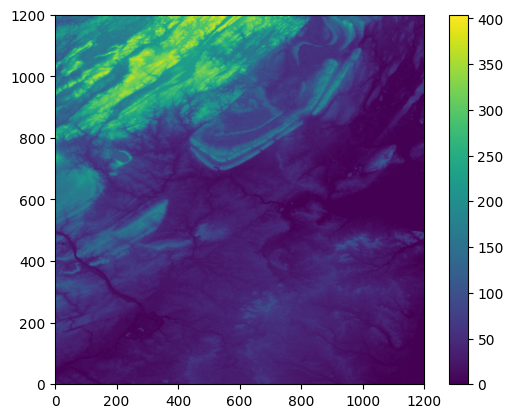

In [988]:
test = alt.copy()
test[test<0]=0
plt.imshow(test.T,origin='lower')
plt.colorbar()

In [991]:
from shapely.geometry import Point
import random

In [992]:
pt_list = []
el_list = []
for k in range(1000):
    i=random.randint(0,len(lon)-1)
    j=random.randint(0,len(lat)-1)
    pt_list.append(Point(lon[i],lat[j]))
    el_list.append(alt[i,j])

In [993]:
el_map = gpd.GeoDataFrame(el_list, geometry = pt_list,crs=4326).rename(columns={0:'elevation'})

In [994]:
el_map.drop_duplicates().to_file('el2.geojson',driver='GeoJSON')